In [1]:
!nvidia-smi

Tue Nov  8 12:46:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   49C    P5    39W / 270W |   2256MiB /  8192MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [3]:
import torchvision
import torch

# Load Data From Library

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(0.1306,0.3081)])
dataset_train = torchvision.datasets.MNIST(root="./",transform = transform,train = True) #download=True
dataset_test  = torchvision.datasets.MNIST(root="./",transform = transform,train = False)

In [5]:
print(dataset_train)
print(dataset_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.1306, std=0.3081)
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.1306, std=0.3081)
           )


# Load Data into Dataloader

In [6]:
#load data
from torch.utils.data import DataLoader

In [27]:
dataloader_train = DataLoader(dataset = dataset_train , batch_size = 8, shuffle = True)
dataloader_test = DataLoader(dataset = dataset_test , batch_size = 10000, shuffle = True)

In [8]:
print(len(dataloader_train))
print(len(dataloader_test))

7500
1250


In [9]:
60000/8

7500.0

# View and Verify Data

In [10]:
for img, targ in dataloader_train:
    print(img.shape)
    print(targ.shape)
    break

torch.Size([8, 1, 28, 28])
torch.Size([8])


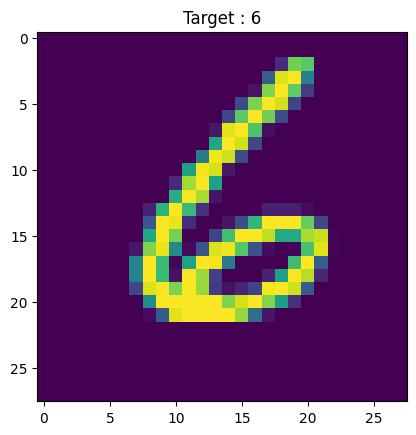

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
for i in range(7):
    plt.imshow(img[i].squeeze(0))
    plt.title("Target : " + str(targ[i].item()))
    plt.show()
    time.sleep(0.5)
    clear_output(wait=True)

In [ ]:
figure, axis = plt.subplots(2, 4)

axis[0, 0].imshow(img[0].squeeze(0))
axis[0, 1].imshow(img[1].squeeze(0))
axis[0, 2].imshow(img[2].squeeze(0))
axis[0, 3].imshow(img[3].squeeze(0))
axis[1, 0].imshow(img[4].squeeze(0))
axis[1, 1].imshow(img[5].squeeze(0))
axis[1, 2].imshow(img[6].squeeze(0))
axis[1, 3].imshow(img[7].squeeze(0))
plt.show()

# Create Model

In [12]:
import torch.nn as nn

In [13]:
class Model(nn.Module):
    def __init__(self,nm_class = 10):
        super(Model,self).__init__()
        self.nm_class = nm_class
        self.linear1 = nn.Linear(28*28,28*28*2)
        self.linear2 = nn.Linear(28*28*2,10)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(28*28*2)

    def forward(self, x):
        # we have image (8,1,28,28), we want to (8,28*28)
        x = x.reshape(x.shape[0],-1)
        x = self.linear1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [14]:
model = Model(10).to("cuda")
print(model)

Model(
  (linear1): Linear(in_features=784, out_features=1568, bias=True)
  (linear2): Linear(in_features=1568, out_features=10, bias=True)
  (relu): ReLU()
  (bn): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


# Test Model with Fake Data

In [15]:
# fake data
f_data = torch.rand((8,28,28)).to("cuda")
outp = model(f_data)
print(f_data.shape)
print(outp.shape)

torch.Size([8, 28, 28])
torch.Size([8, 10])


# Create Loss and Optim

In [16]:
#init loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),lr = 0.0003)

# Training

In [18]:
#train
for epc in range(10):
    model.train()
    num_cor = 0
    num_samp = 0
    loss_list = []
    for data,target in dataloader_train:
        data = data.to("cuda")
        target = target.to("cuda")

        #forward
        output = model(data)
        loss = criterion(output,target)
        loss_list.append(loss)
        
        _,pred = output.max(1)

        num_cor += (pred == target).sum()
        num_samp += pred.size(0)
        

        #backward
        optimizer.zero_grad()
        loss.backward()

        #grad decent or adam
        optimizer.step()
    acc = num_cor/num_samp
    print("EPC : "+str(epc)+"   Acc:  "+str(acc))

EPC : 0   Acc:  tensor(0.9088, device='cuda:0')
EPC : 1   Acc:  tensor(0.9453, device='cuda:0')
EPC : 2   Acc:  tensor(0.9561, device='cuda:0')
EPC : 3   Acc:  tensor(0.9625, device='cuda:0')
EPC : 4   Acc:  tensor(0.9678, device='cuda:0')
EPC : 5   Acc:  tensor(0.9691, device='cuda:0')
EPC : 6   Acc:  tensor(0.9723, device='cuda:0')
EPC : 7   Acc:  tensor(0.9750, device='cuda:0')
EPC : 8   Acc:  tensor(0.9770, device='cuda:0')
EPC : 9   Acc:  tensor(0.9783, device='cuda:0')


# Save and Load Model

In [19]:
torch.save(model, "modelsave.pt")

In [20]:
model = torch.load("./modelsave.pt")
model.eval()

Model(
  (linear1): Linear(in_features=784, out_features=1568, bias=True)
  (linear2): Linear(in_features=1568, out_features=10, bias=True)
  (relu): ReLU()
  (bn): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# Predicting

----------------------STARTING TO PREDICT----------------------
6
6


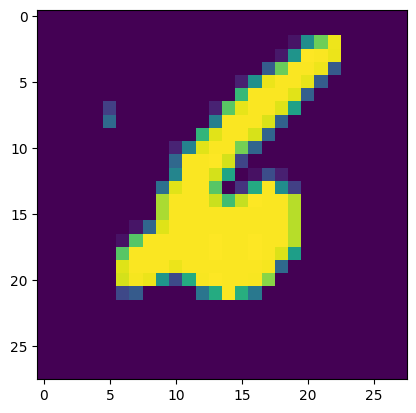

In [28]:
index = 555
for imgt, targt in dataloader_test:
    # print(imgt.size())
    # print(imgt[1].size())
    print("----------------------STARTING TO PREDICT----------------------")
    pred = model(imgt.to("cuda"))
    print(targt[index].item())
    print(pred[index].argmax().item())
    plt.imshow(imgt[index].squeeze(0))
    break

In [46]:
count_correct = 0
for imgt, targt in dataloader_test:
    
    print(imgt.size())
    print(targt.size())
    pred = model(imgt.to("cuda"))
    
    print(pred.size())
    for i in range(10000):
        prediction = pred[i].argmax().item()
        actual = targt[i].item()
        if prediction == actual:
            count_correct += 1
    

torch.Size([10000, 1, 28, 28])
torch.Size([10000])
torch.Size([10000, 10])


In [47]:
print(count_correct)

9807


In [50]:
accur = count_correct/10000
print(accur)

0.9807
